In [1]:
import pandas as pd

# Load the CSV file
data = pd.read_csv("phones.csv")

In [2]:
columns_to_drop = ["Image Link 1", "Image Link 2", "Expert Comment"]
data = data.drop(columns_to_drop, axis=1)

In [3]:
data.head(1)

,Phone Name,Price,Performance,Display,Camera,Battery
0,Samsung Galaxy S23 Ultra 5G,104999,"Octa core (3.36 GHz, Single Core + 2.8 GHz, Qu...","6.8 inches (17.27 cm)\n501 PPI, Dynamic AMOLED...",200 + 12 + 10 + 10 MP Quad Primary Cameras\nLE...,5000 mAh\nFast Charging\nUSB Type-C Port\n


In [4]:
data.shape

(44, 6)

## Performance

In [5]:
performance_df=data.copy()
columns_to_drop = list(performance_df.columns)

In [6]:
performance_df[['Core', 'Processor', 'RAM']] = performance_df['Performance'].str.split('\n', expand=True).iloc[:,:-1]
performance_df = performance_df.drop(columns_to_drop, axis=1)

In [7]:
performance_df["Processor"].unique()

array(['Snapdragon 8 Gen 2', 'Apple A16 Bionic',
       'MediaTek Dimensity 9200', 'Google Tensor G2',
       'MediaTek Dimensity 9000 Plus', 'Apple A15 Bionic',
       'Snapdragon 8 Plus Gen 1', 'Snapdragon 8 Gen 1',
       'MediaTek Dimensity 9000', 'MediaTek Dimensity 7050',
       'Snapdragon 888', 'Snapdragon 888 Plus', 'MediaTek Dimensity 8100',
       'MediaTek Dimensity 8100 Max', 'Snapdragon 870',
       'MediaTek Dimensity 920', 'MediaTek Dimensity 1200'], dtype=object)

In [8]:
def calculate_phone_score(core, processor, ram):
    # Define a dictionary to assign points based on processors
    processor_scores = {
        'Snapdragon 8 Gen 2':1, 
        'Apple A16 Bionic':8,
       'MediaTek Dimensity 9200':2, 
        'Google Tensor G2':3,
       'MediaTek Dimensity 9000 Plus':2,
        'Apple A15 Bionic':8,
       'Snapdragon 8 Plus Gen 1':5, 
        'Snapdragon 8 Gen 1':4,
       'MediaTek Dimensity 9000':3,
        'MediaTek Dimensity 7050':3,
       'Snapdragon 888':3.5,
        'Snapdragon 888 Plus':4,
        'MediaTek Dimensity 8100':3,
       'MediaTek Dimensity 8100 Max':3.5,
        'Snapdragon 870':3.5,
       'MediaTek Dimensity 920':2,
        'MediaTek Dimensity 1200':2.5,
        # Add more processors and their scores as needed
    }

    # Assign base scores based on core count and RAM size
    core_score = 0
    if 'Octa core' in core:
        core_score = 4
    elif 'Hexa core' in core:
        core_score = 3
    elif 'Quad core' in core:
        core_score = 2
    elif 'Dual core' in core:
        core_score = 1

    ram_score = 0
    if '12 GB' in ram:
        ram_score = 4
    elif '8 GB' in ram:
        ram_score = 3
    elif '6 GB' in ram:
        ram_score = 2
    elif '4 GB' in ram:
        ram_score = 1

    # Get additional processor score from the dictionary
    processor_score = processor_scores.get(processor, 0)

    # Calculate the total score
    total_score = core_score + ram_score + processor_score
    return total_score

# Apply the function to the DataFrame to calculate the scores
data['Performance_Score'] = performance_df.apply(lambda row: calculate_phone_score(row['Core'], row['Processor'], row['RAM']), axis=1)

## Display

In [9]:
display_df=data.copy()
columns_to_drop = list(display_df.columns)

In [10]:
display_df[['Size', 'Screen_Type', 'Refresh_Rate']]=display_df['Display'].str.split('\n', expand=True).iloc[:,:-1]
display_df = display_df.drop(columns_to_drop, axis=1)

In [11]:
def calculate_display_score(size, screen_type, refresh_rate):
    # Score based on screen size (larger screen size gets higher score)
    size_score = float(size.split()[0])
    
    # Score based on screen type (higher PPI gets higher score, AMOLED screen gets additional points)
    try:
        ppi = float(screen_type.split()[0])
        screen_type_score = ppi / 100  # Scale down PPI to be in a reasonable range
        if 'AMOLED' in screen_type.upper():
            screen_type_score += 5  # Additional points for AMOLED screen
        elif 'OLED' in screen_type.upper():
            screen_type_score += 3     
    except (ValueError, IndexError):
        screen_type_score = 0
    
    # Score based on refresh rate (higher refresh rate gets higher score)
    refresh_rate_score = 0
    if '90 Hz' in refresh_rate:
        refresh_rate_score = 1
    elif '120 Hz' in refresh_rate:
        refresh_rate_score = 2
    elif '144 Hz' in refresh_rate:
        refresh_rate_score = 3    
    
    
    # Calculate the total score
    total_score = size_score + screen_type_score + refresh_rate_score
    return total_score

# Apply the function to the DataFrame to calculate the scores
data['Display_Score'] = display_df.apply(lambda row: calculate_display_score(row['Size'], row['Screen_Type'], row['Refresh_Rate']), axis=1)

## Battery

In [12]:
# df=data
# columns_to_drop = list(df.columns)

In [13]:
# df[['Capacity', 'Charge_Type']]=df['Battery'].str.split('\n', expand=True).iloc[:,:-2]
# df = df.drop(columns_to_drop, axis=1)

In [14]:
# data.shape

## Camera

## Normalization

In [15]:
def min_max_scaling(column):
    min_val = column.min()
    max_val = column.max()
    normalized_column = (column - min_val) / (max_val - min_val)
    return (normalized_column*5).round(2)

# Apply the min-max scaling function to the 'Column1' and store the result in a new column
data['Performance_Score'] = min_max_scaling(data['Performance_Score'])
data['Display_Score'] = min_max_scaling(data['Display_Score'])

In [16]:
data

,Phone Name,Price,Performance,Display,Camera,Battery,Performance_Score,Display_Score
0,Samsung Galaxy S23 Ultra 5G,104999,"Octa core (3.36 GHz, Single Core + 2.8 GHz, Qu...","6.8 inches (17.27 cm)\n501 PPI, Dynamic AMOLED...",200 + 12 + 10 + 10 MP Quad Primary Cameras\nLE...,5000 mAh\nFast Charging\nUSB Type-C Port\n,1.0,4.09
1,Apple iPhone 14 Pro Max,127999,"Hexa Core (3.46 GHz, Dual Core + 2.02 GHz, Qua...","6.7 inches (17.02 cm)\n460 PPI, OLED\n120 Hz R...",48 MP + 12 MP + 12 MP Triple Primary Cameras\n...,4323 mAh\nFast Charging\nLightning Port\n,4.0,2.09
2,vivo X90 Pro,76499,"Octa core (3.05 GHz, Single Core + 2.85 GHz, T...","6.78 inches (17.22 cm)\n453 PPI, AMOLED\n120 H...",50 MP + 12 MP + 50 MP Triple Primary Cameras\n...,4870 mAh\nFlash Charging\nUSB Type-C Port\n,2.0,3.69
3,Xiaomi 13 Pro,74999,"Octa core (3.2 GHz, Single Core + 2.8 GHz, Qua...","6.73 inches (17.09 cm)\n521 PPI, AMOLED\n120 H...",50 MP + 50 MP + 50 MP Triple Primary Cameras\n...,4820 mAh\nFast Charging\nUSB Type-C Port\n,1.0,4.19
4,Google Pixel 7 Pro 5G,58999,"Octa core (2.85 GHz, Dual Core + 2.35 GHz, Dua...","6.7 inches (17.02 cm)\n513 PPI, OLED\n120 Hz R...",50 MP + 12 MP + 48 MP Triple Primary Cameras\n...,5000 mAh\nFast Charging\nUSB Type-C Port\n,3.0,2.51
5,OPPO Find N2 Flip,81999,"Octa core (3.2 GHz, Single Core + 3 GHz, Tri c...","6.8 inches (17.27 cm)\n403 PPI, AMOLED\n120 Hz...",50 MP + 8 MP Dual Primary Cameras\nLED Flash\n...,4300 mAh\nSuper VOOC Charging\nUSB Type-C Port\n,1.0,3.31
6,Samsung Galaxy S23 Plus 5G,94999,"Octa core (3.36 GHz, Single Core + 2.8 GHz, Qu...","6.6 inches (16.76 cm)\n390 PPI, Dynamic AMOLED...",50 MP + 12 MP + 10 MP Triple Primary Cameras\n...,4700 mAh\nFast Charging\nUSB Type-C Port\n,0.0,3.04
7,Samsung Galaxy S23 5G,64450,"Octa core (3.36 GHz, Single Core + 2.8 GHz, Qu...","6.1 inches (15.49 cm)\n422 PPI, Dynamic AMOLED...",50 MP + 12 MP + 10 MP Triple Primary Cameras\n...,3900 mAh\nFast Charging\nUSB Type-C Port\n,0.0,2.90
8,Apple iPhone 13 Pro Max,129900,"Hexa Core (3.23 GHz, Dual Core + 1.82 GHz, Qua...","6.7 inches (17.02 cm)\n457 PPI, OLED\n120 Hz R...",12 MP + 12 MP + 12 MP Triple Primary Cameras\n...,4352 mAh\nFast Charging\nLightning Port\n,4.0,2.07
9,Samsung Galaxy Z Fold 4 5G,124999,"Octa core (3.18 GHz, Single Core + 2.7 GHz, Tr...","7.6 inches (19.3 cm)\n373 PPI, Dynamic AMOLED\...",50 MP + 12 MP + 10 MP Triple Primary Cameras\n...,4400 mAh\nFast Charging\nUSB Type-C Port\n,5.0,3.70


In [19]:
# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt

# plt.figure(figsize=(18,16))
# sns.scatterplot(x='Performance_Score', y='Display_Score', data=data, hue='Phone Name', s=100, palette='Set1')
# plt.title('Tradeoff between Performance and Display')
# plt.xlabel('Performance')
# plt.ylabel('Display')
# plt.legend(title='Phone', bbox_to_anchor=(1, 1))
# plt.grid(True)
# plt.show()

In [20]:
name = data['Phone Name'].to_numpy()
pscore = data['Performance_Score'].to_numpy()
dscore = data['Display_Score'].to_numpy()

In [31]:
print(name)
print(dscore)

['Samsung Galaxy S23 Ultra 5G' 'Apple iPhone 14 Pro Max' 'vivo X90 Pro'
 'Xiaomi 13 Pro' 'Google Pixel 7 Pro 5G' 'OPPO Find N2 Flip'
 'Samsung Galaxy S23 Plus 5G' 'Samsung Galaxy S23 5G'
 'Apple iPhone 13 Pro Max' 'Samsung Galaxy Z Fold 4 5G'
 'Samsung Galaxy S22 Ultra' 'vivo X80 Pro 5G' 'OnePlus 11'
 'OnePlus Nord 3 5G' 'OPPO Reno10 Pro+ 5G' 'realme 11 Pro Plus'
 'Apple iPhone 14 Plus' 'Samsung Galaxy Z Flip 4 5G' 'iQOO 11 5G'
 'OnePlus 11R' 'Xiaomi 12 Pro 5G' 'iQOO Neo 7 Pro' 'OnePlus 10 Pro'
 'Samsung Galaxy S22 Plus' 'vivo X80 5G' 'Samsung Galaxy Z Fold 3'
 'Samsung Galaxy Z Flip 3' 'iQOO 9 Pro 5G' 'vivo X70 Pro Plus'
 'iQOO 9T 5G' 'OnePlus 10T' 'realme GT 2 Pro 5G' 'Apple iPhone 13'
 'realme GT Neo 3 5G 150W' 'OnePlus 10R 5G' 'POCO F4 5G'
 'OPPO Reno8 Pro 5G' 'Asus ROG Phone 5' 'iQOO 7 Legend' 'realme GT 5G'
 'realme 9 Pro Plus' 'realme GT Neo 2 5G' 'realme X7 Max'
 'OnePlus Nord 2 8GB RAM']
[4.09 2.09 3.69 4.19 2.51 3.31 3.04 2.9  2.07 3.7  4.09 4.21 4.21 3.64
 2.05 3.16 0.48 3.4

In [37]:
import numpy
plt.bar(x=numpy.arange(2), y=[dscore[1],pscore[1]], kind="bar")

TypeError: bar() missing 1 required positional argument: 'height'

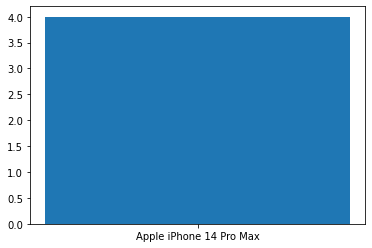

In [26]:
plt.bar(name[1],[dscore[1],pscore[1]])
plt.show()